In [1]:
import tqdm
import pandas as pd
import numpy as np
import neurokit2 as nk

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'''\usepackage{libertine}\usepackage{fontawesome5}\usepackage[dvipsnames]{xcolor}'''
plt.rcParams['ps.usedistiller'] = 'xpdf'
import seaborn as sns
sns.set_theme(style='ticks')

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_event_intervals(dfAdaptation) -> list:
    intervals = []
    workloads = []
    currentTime = 0
    currentDirection = 'less'
    currentWorkload = 'low'
    for idx, row in dfAdaptation.iterrows():
        if idx == 0:
            currentTime = row['Time']
            currentDirection = row['Direction']
            continue
        if currentDirection == row['Direction']:
            currentTime = row['Time']
            currentDirection = row['Direction']
        if currentDirection != row['Direction']:
            intervals.append((currentTime, row['Time']))
            currentTime = row['Time']
            oldDirection = currentDirection
            currentDirection = row['Direction']
            if oldDirection == 'less' and currentDirection == 'more':
                currentWorkload = 'low'
            elif oldDirection == 'more' and currentDirection == 'less':
                currentWorkload = 'high'
            workloads.append(currentWorkload)
    return intervals, workloads

def load_ecg(pid):

    dfECG = pd.read_csv(f"./data/ID{pid}-ECG.csv")
    dfState = pd.read_csv(f"./data/ID{pid}-state.csv")
    dfAdaptation = pd.read_csv(f"./data/ID{pid}-adaptation.csv")
    dfECG.drop("TimeLsl", axis =1, inplace=True)
    intervals, workloads = get_event_intervals(dfAdaptation)
    for idx, interval in enumerate(intervals):
        dfECG.loc[(dfECG['Time'] >= interval[0]) & (dfECG['Time'] <= interval[1]), 'workload'] = workloads[idx]
        dfECG.loc[(dfECG['Time'] >= interval[0]) & (dfECG['Time'] <= interval[1]), 'interval_id'] = idx
    dfECG = dfECG[dfECG['workload'].notna()]

    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][0]) & (dfECG.Time < dfState['Time'][0+1])].index, 'BlockNumber']   = dfState['BlockNumber'][0]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][2]) & (dfECG.Time < dfState['Time'][2+1])].index, 'BlockNumber']   = dfState['BlockNumber'][2]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][4]) & (dfECG.Time < dfState['Time'][4+1])].index, 'BlockNumber']   = dfState['BlockNumber'][4]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][6]) & (dfECG.Time < dfState['Time'][6+1])].index, 'BlockNumber']   = dfState['BlockNumber'][6]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][8]) & (dfECG.Time < dfState['Time'][8+1])].index, 'BlockNumber']  = dfState['BlockNumber'][8]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][10]) & (dfECG.Time < dfState['Time'][10+1])].index, 'BlockNumber'] = dfState['BlockNumber'][10]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][12]) & (dfECG.Time < dfState['Time'][12+1])].index, 'BlockNumber'] = dfState['BlockNumber'][12]
    dfECG = dfECG.dropna()
    dfECG = dfECG.sort_values(by="Time")
    return dfECG

def extract_ecg_features(pid, df):
    df_features = pd.DataFrame()
    intervals = df.interval_id.unique()
    for interval_id in intervals:
        df_current = df[df.interval_id == interval_id]

        if len(df_current['Value']) < 230:
            df_features = df_features.append(pd.DataFrame.from_dict([{
                'pid': pid,
                'workload': df_current['workload'].iloc[0],
                'interval': interval_id,
            }]))
            continue

        print('processing size: ', len(df_current['Value']))

        # # H10 Technical Specification
        # # Sample rate = 130 Hz ± 2 % (Tamb = +20 … +40 °C)
        # #               130 Hz ± 5 % (Tamb = -20 … +70 °C)
        # # https://github.com/polarofficial/polar-ble-sdk/blob/master/technical_documentation/H10_ECG_Explained.docx
        s, _ = nk.ecg_process(df_current['Value'], sampling_rate=130)
        peaks, _ = nk.ecg_peaks(nk.ecg_clean(df_current['Value'], sampling_rate=130),
                                sampling_rate=130,
                                correct_artifacts=True)

        try:
            hrv_rmssd = np.mean(nk.hrv(peaks, sampling_rate=130)['HRV_RMSSD'])
        except Exception:
            hrv_rmssd = np.NaN


        df_features = df_features.append(pd.DataFrame.from_dict([{
            'pid': pid,
            'workload': df_current['workload'].iloc[0],
            'block_number': df_current['BlockNumber'].iloc[0],
            'interval': interval_id,
            # https://neuropsychology.github.io/NeuroKit/functions/ecg.html?highlight=ecg_rate
            'ecg_rate_mean': np.mean(s['ECG_Rate']),
            'ecg_rate_var': np.var(s['ECG_Rate']),
            # https://neuropsychology.github.io/NeuroKit/examples/ecg_hrv/ecg_hrv.html?highlight=rmssd
            'hrv_rmssd': hrv_rmssd,
        }]))
    return df_features

In [3]:
pid_valid = list(range(1, 24))
df_all = {}

for pid in tqdm.tqdm(pid_valid):
    if pid == 4 or pid == 8 or pid == 10 or pid == 15 or pid == 16 or pid == 17 or pid == 21:
        continue
    df = load_ecg(pid)
    df_all[pid] = df

100%|██████████| 23/23 [00:03<00:00,  6.26it/s]


In [4]:
df = pd.DataFrame()
for pid in pid_valid:
    print('current pid: ', pid)
    if pid == 4 or pid == 8 or pid == 10 or pid == 15 or pid == 16 or pid == 17 or pid == 21:
        continue
    df_features = extract_ecg_features(pid, df_all[pid])
    df = df.append(df_features)
df

current pid:  1
processing size:  2664
processing size:  2664
processing size:  2664
processing size:  2590
processing size:  2664
processing size:  2664
processing size:  2664
processing size:  2590
processing size:  2590
processing size:  2664
processing size:  2738
processing size:  2664
processing size:  2738
current pid:  2
processing size:  2590
processing size:  2516
processing size:  2664
processing size:  2590
processing size:  2590
processing size:  2664
processing size:  2688
processing size:  2590
processing size:  2664
processing size:  2664
processing size:  2590
current pid:  3
processing size:  2664
processing size:  2664
processing size:  2590
processing size:  2664
processing size:  2664
processing size:  2664
processing size:  2664
processing size:  2664
processing size:  2664
processing size:  2590
processing size:  2640
processing size:  2590
processing size:  2664
processing size:  2738
processing size:  2664
processing size:  2664
processing size:  2688
current p

,pid,workload,block_number,interval,ecg_rate_mean,ecg_rate_var,hrv_rmssd
0,1,low,6.0,0.0,86.202923,585.809445,316.134194
0,1,high,6.0,1.0,91.153597,726.346759,323.063356
0,1,low,6.0,2.0,90.731661,536.064351,326.662373
0,1,high,6.0,3.0,105.092963,623.102870,268.057195
0,1,low,7.0,4.0,101.749400,912.095071,322.784895
...,...,...,...,...,...,...,...
0,23,low,7.0,10.0,104.721125,1048.290171,314.809513
0,23,high,7.0,11.0,97.288675,585.334778,270.498845
0,23,low,7.0,12.0,106.591597,767.416870,259.291108
0,23,high,7.0,13.0,107.165107,787.030933,316.192680


In [5]:
df['ecg_rate_mean_norm'] = (df['ecg_rate_mean'] - df['ecg_rate_mean'].min()) / (df['ecg_rate_mean'].max() - df['ecg_rate_mean'].min())
df['hrv_rmssd_norm'] = (df['hrv_rmssd'] - df['hrv_rmssd'].min()) / (df['hrv_rmssd'].max() - df['hrv_rmssd'].min())

In [6]:
df = df[(df.block_number == 6) | (df.block_number == 7)]
df.to_csv("./processed/ecg.csv", index=False)

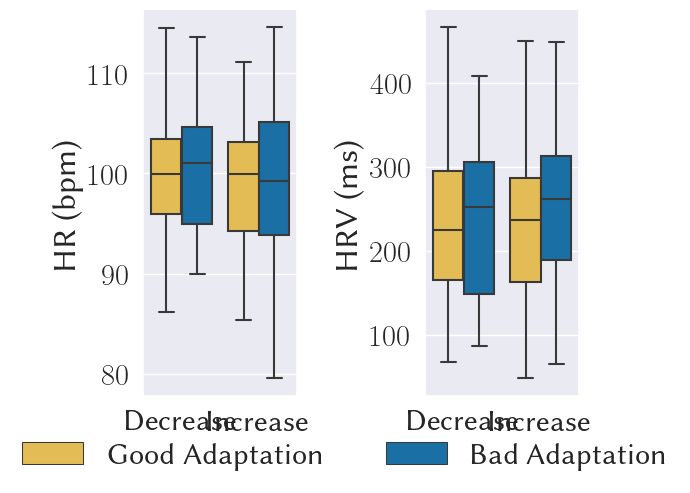

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(6, 5))

colors = list({'yellow' : '#FBC63D', 'blue': '#0376BB'}.values())
sns.boxplot(x='workload', y='ecg_rate_mean', data=df, hue='block_number', ax=axes[0], palette=colors, showfliers=False)
sns.boxplot(x='workload', y='hrv_rmssd', data=df, hue='block_number', ax=axes[1], palette=colors, showfliers=False)

axes[0].set_ylabel('HR (bpm)')
axes[1].set_ylabel('HRV (ms)')

axes[0].set_xticklabels(['Decrease', 'Increase'])
axes[1].set_xticklabels(['Decrease', 'Increase'])

axes[0].set_xlabel('')
axes[1].set_xlabel('')

axes[0].legend().set_visible(False)
axes[1].legend().set_visible(False)
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, ['Good Adaptation', 'Bad Adaptation'], loc='lower center', ncol=2, bbox_to_anchor=(0.55, -.05), frameon=False)

plt.tight_layout()
plt.savefig('figures/fig1ecg.pdf')

In [1]:
import tqdm
import pandas as pd
import numpy as np
import neurokit2 as nk
import mne
from mne_icalabel import label_components
mne.set_log_level('WARNING')
from scipy.integrate import simpson # composite Simpson's rule

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'''\usepackage{libertine}\usepackage{fontawesome5}\usepackage[dvipsnames]{xcolor}'''
plt.rcParams['ps.usedistiller'] = 'xpdf'
import seaborn as sns
sns.set_theme(style='ticks')

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('processed/ecg.csv')

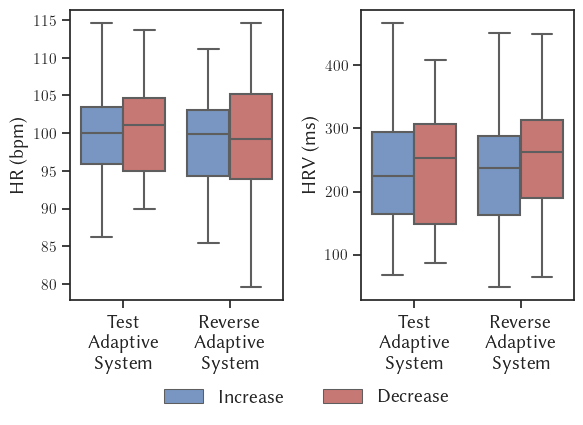

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
colors = sns.color_palette('vlag', n_colors=5)
# colors = sns.color_palette('coolwarm', n_colors=10)
colors = [colors[0], colors[-1]]
# colors = sns.diverging_palette(220, 20, as_cmap=False, n=2)
saturation = 1
# colors = list({'yellow' : '#458a57', 'blue': '#ab334d'}.values())
sns.boxplot(x='workload', y='ecg_rate_mean', data=df, hue='block_number', ax=axes[0], palette=colors, showfliers=False, saturation=saturation)
sns.boxplot(x='workload', y='hrv_rmssd', data=df, hue='block_number', ax=axes[1], palette=colors, showfliers=False, saturation=saturation)


axes[0].set_ylabel('HR (bpm)', fontsize=14)
axes[1].set_ylabel('HRV (ms)', fontsize=14)

axes[0].set_xticklabels(['Test \nAdaptive\nSystem', 'Reverse \nAdaptive\nSystem'], fontsize=14)
axes[1].set_xticklabels(['Test \nAdaptive\nSystem', 'Reverse \nAdaptive\nSystem'], fontsize=14)

axes[0].set_xlabel('')
axes[1].set_xlabel('')

axes[0].legend().remove()
axes[1].legend().remove()

# fig.suptitle('Adaptation Visual Complexity (EDA)')

# create legend
handles, _ = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Increase', 'Decrease'], loc='upper center', ncol=2, bbox_to_anchor=(0.525, 0.05), frameon=False, fontsize=14)

plt.tight_layout()
plt.savefig('figures/fig4b.pdf', bbox_inches='tight')